# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [20]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [21]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

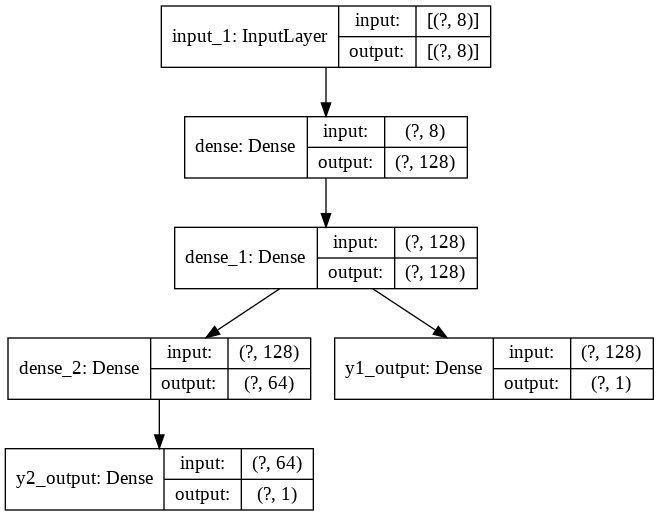

In [24]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [26]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [27]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 921us/sample - loss: 264.0031 - y1_output_loss: 126.2784 - y2_output_loss: 135.7129 - y1_output_root_mean_squared_error: 11.2838 - y2_output_root_mean_squared_error: 11.6910 - val_loss: 32.2714 - val_y1_output_loss: 13.2921 - val_y2_output_loss: 18.2725 - val_y1_output_root_mean_squared_error: 3.7053 - val_y2_output_root_mean_squared_error: 4.3061
Epoch 2/500
614/614 [==============================] - 0s 137us/sample - loss: 35.1993 - y1_output_loss: 12.8815 - y2_output_loss: 22.2347 - y1_output_root_mean_squared_error: 3.5963 - y2_output_root_mean_squared_error: 4.7187 - val_loss: 21.8331 - val_y1_output_loss: 9.5593 - val_y2_output_loss: 11.9382 - val_y1_output_root_mean_squared_error: 3.1333 - val_y2_output_root_mean_squared_error: 3.4664
Epoch 3/500
614/614 [==============================] - 0s 151us/sample - loss: 28.8384 - y1_output_loss: 10.5017 - y2_output_loss: 18.7860 - y1_

614/614 [==============================] - 0s 124us/sample - loss: 12.3680 - y1_output_loss: 4.5904 - y2_output_loss: 7.7225 - y1_output_root_mean_squared_error: 2.1516 - y2_output_root_mean_squared_error: 2.7818 - val_loss: 22.0230 - val_y1_output_loss: 7.0468 - val_y2_output_loss: 14.3349 - val_y1_output_root_mean_squared_error: 2.6892 - val_y2_output_root_mean_squared_error: 3.8459
Epoch 22/500
614/614 [==============================] - 0s 124us/sample - loss: 12.2747 - y1_output_loss: 4.5061 - y2_output_loss: 7.7188 - y1_output_root_mean_squared_error: 2.1282 - y2_output_root_mean_squared_error: 2.7831 - val_loss: 14.2592 - val_y1_output_loss: 6.2024 - val_y2_output_loss: 7.7260 - val_y1_output_root_mean_squared_error: 2.5114 - val_y2_output_root_mean_squared_error: 2.8200
Epoch 23/500
614/614 [==============================] - 0s 123us/sample - loss: 11.2874 - y1_output_loss: 4.3343 - y2_output_loss: 7.4180 - y1_output_root_mean_squared_error: 2.0369 - y2_output_root_mean_squared_

614/614 [==============================] - 0s 124us/sample - loss: 7.3994 - y1_output_loss: 2.4974 - y2_output_loss: 5.0527 - y1_output_root_mean_squared_error: 1.5669 - y2_output_root_mean_squared_error: 2.2235 - val_loss: 31.0942 - val_y1_output_loss: 7.6652 - val_y2_output_loss: 22.4967 - val_y1_output_root_mean_squared_error: 2.8041 - val_y2_output_root_mean_squared_error: 4.8199
Epoch 42/500
614/614 [==============================] - 0s 127us/sample - loss: 7.8859 - y1_output_loss: 2.5430 - y2_output_loss: 5.4071 - y1_output_root_mean_squared_error: 1.5872 - y2_output_root_mean_squared_error: 2.3166 - val_loss: 8.0052 - val_y1_output_loss: 3.6292 - val_y2_output_loss: 4.2223 - val_y1_output_root_mean_squared_error: 1.9095 - val_y2_output_root_mean_squared_error: 2.0878
Epoch 43/500
614/614 [==============================] - 0s 125us/sample - loss: 7.1151 - y1_output_loss: 2.4086 - y2_output_loss: 4.6431 - y1_output_root_mean_squared_error: 1.5588 - y2_output_root_mean_squared_erro

Epoch 62/500
614/614 [==============================] - 0s 122us/sample - loss: 5.1988 - y1_output_loss: 1.7738 - y2_output_loss: 3.4202 - y1_output_root_mean_squared_error: 1.3370 - y2_output_root_mean_squared_error: 1.8469 - val_loss: 7.5933 - val_y1_output_loss: 2.2084 - val_y2_output_loss: 5.2213 - val_y1_output_root_mean_squared_error: 1.4825 - val_y2_output_root_mean_squared_error: 2.3228
Epoch 63/500
614/614 [==============================] - 0s 122us/sample - loss: 6.3707 - y1_output_loss: 1.7371 - y2_output_loss: 4.6046 - y1_output_root_mean_squared_error: 1.3234 - y2_output_root_mean_squared_error: 2.1492 - val_loss: 11.9899 - val_y1_output_loss: 4.0870 - val_y2_output_loss: 7.6744 - val_y1_output_root_mean_squared_error: 2.0277 - val_y2_output_root_mean_squared_error: 2.8068
Epoch 64/500
614/614 [==============================] - 0s 122us/sample - loss: 5.7421 - y1_output_loss: 1.8702 - y2_output_loss: 3.8225 - y1_output_root_mean_squared_error: 1.3735 - y2_output_root_mean_

Epoch 83/500
614/614 [==============================] - 0s 122us/sample - loss: 2.5692 - y1_output_loss: 0.6648 - y2_output_loss: 1.9067 - y1_output_root_mean_squared_error: 0.8149 - y2_output_root_mean_squared_error: 1.3803 - val_loss: 3.4638 - val_y1_output_loss: 1.2943 - val_y2_output_loss: 2.1564 - val_y1_output_root_mean_squared_error: 1.1115 - val_y2_output_root_mean_squared_error: 1.4928
Epoch 84/500
614/614 [==============================] - 0s 122us/sample - loss: 7.3191 - y1_output_loss: 2.1652 - y2_output_loss: 5.1118 - y1_output_root_mean_squared_error: 1.4771 - y2_output_root_mean_squared_error: 2.2666 - val_loss: 3.7860 - val_y1_output_loss: 1.0361 - val_y2_output_loss: 2.7087 - val_y1_output_root_mean_squared_error: 0.9975 - val_y2_output_root_mean_squared_error: 1.6706
Epoch 85/500
614/614 [==============================] - 0s 122us/sample - loss: 3.6489 - y1_output_loss: 0.9212 - y2_output_loss: 2.6983 - y1_output_root_mean_squared_error: 0.9623 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 129us/sample - loss: 2.2422 - y1_output_loss: 0.5984 - y2_output_loss: 1.6553 - y1_output_root_mean_squared_error: 0.7654 - y2_output_root_mean_squared_error: 1.2870 - val_loss: 3.1341 - val_y1_output_loss: 0.9376 - val_y2_output_loss: 2.1702 - val_y1_output_root_mean_squared_error: 0.9438 - val_y2_output_root_mean_squared_error: 1.4978
Epoch 105/500
614/614 [==============================] - 0s 132us/sample - loss: 2.6203 - y1_output_loss: 0.6747 - y2_output_loss: 1.9497 - y1_output_root_mean_squared_error: 0.8187 - y2_output_root_mean_squared_error: 1.3964 - val_loss: 2.9724 - val_y1_output_loss: 0.9501 - val_y2_output_loss: 2.0195 - val_y1_output_root_mean_squared_error: 0.9431 - val_y2_output_root_mean_squared_error: 1.4432
Epoch 106/500
614/614 [==============================] - 0s 130us/sample - loss: 3.0923 - y1_output_loss: 0.6522 - y2_output_loss: 2.4234 - y1_output_root_mean_squared_error: 0.8083 - y2_output_root_mea

614/614 [==============================] - 0s 124us/sample - loss: 2.7206 - y1_output_loss: 0.7125 - y2_output_loss: 1.9911 - y1_output_root_mean_squared_error: 0.8469 - y2_output_root_mean_squared_error: 1.4154 - val_loss: 2.8478 - val_y1_output_loss: 1.0718 - val_y2_output_loss: 1.7892 - val_y1_output_root_mean_squared_error: 0.9977 - val_y2_output_root_mean_squared_error: 1.3611
Epoch 125/500
614/614 [==============================] - 0s 124us/sample - loss: 1.7836 - y1_output_loss: 0.4377 - y2_output_loss: 1.3370 - y1_output_root_mean_squared_error: 0.6635 - y2_output_root_mean_squared_error: 1.1590 - val_loss: 3.0936 - val_y1_output_loss: 0.6859 - val_y2_output_loss: 2.3877 - val_y1_output_root_mean_squared_error: 0.7882 - val_y2_output_root_mean_squared_error: 1.5724
Epoch 126/500
614/614 [==============================] - 0s 124us/sample - loss: 1.7800 - y1_output_loss: 0.4612 - y2_output_loss: 1.3089 - y1_output_root_mean_squared_error: 0.6778 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 124us/sample - loss: 2.1304 - y1_output_loss: 0.4989 - y2_output_loss: 1.6156 - y1_output_root_mean_squared_error: 0.7079 - y2_output_root_mean_squared_error: 1.2764 - val_loss: 3.2926 - val_y1_output_loss: 0.9314 - val_y2_output_loss: 2.3322 - val_y1_output_root_mean_squared_error: 0.9341 - val_y2_output_root_mean_squared_error: 1.5557
Epoch 146/500
614/614 [==============================] - 0s 124us/sample - loss: 1.9497 - y1_output_loss: 0.4327 - y2_output_loss: 1.5189 - y1_output_root_mean_squared_error: 0.6575 - y2_output_root_mean_squared_error: 1.2318 - val_loss: 2.2148 - val_y1_output_loss: 0.5575 - val_y2_output_loss: 1.7287 - val_y1_output_root_mean_squared_error: 0.6715 - val_y2_output_root_mean_squared_error: 1.3281
Epoch 147/500
614/614 [==============================] - 0s 124us/sample - loss: 1.4768 - y1_output_loss: 0.2924 - y2_output_loss: 1.1725 - y1_output_root_mean_squared_error: 0.5430 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 1.3615 - y1_output_loss: 0.2543 - y2_output_loss: 1.1007 - y1_output_root_mean_squared_error: 0.5044 - y2_output_root_mean_squared_error: 1.0522 - val_loss: 1.8710 - val_y1_output_loss: 0.4156 - val_y2_output_loss: 1.4975 - val_y1_output_root_mean_squared_error: 0.5682 - val_y2_output_root_mean_squared_error: 1.2443
Epoch 166/500
614/614 [==============================] - 0s 132us/sample - loss: 2.0959 - y1_output_loss: 0.5259 - y2_output_loss: 1.5645 - y1_output_root_mean_squared_error: 0.7273 - y2_output_root_mean_squared_error: 1.2518 - val_loss: 3.0613 - val_y1_output_loss: 0.9279 - val_y2_output_loss: 2.1560 - val_y1_output_root_mean_squared_error: 0.9320 - val_y2_output_root_mean_squared_error: 1.4807
Epoch 167/500
614/614 [==============================] - 0s 129us/sample - loss: 2.7639 - y1_output_loss: 0.6417 - y2_output_loss: 2.1122 - y1_output_root_mean_squared_error: 0.7999 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 123us/sample - loss: 1.3431 - y1_output_loss: 0.3270 - y2_output_loss: 1.0105 - y1_output_root_mean_squared_error: 0.5714 - y2_output_root_mean_squared_error: 1.0083 - val_loss: 1.6467 - val_y1_output_loss: 0.6223 - val_y2_output_loss: 1.0517 - val_y1_output_root_mean_squared_error: 0.7474 - val_y2_output_root_mean_squared_error: 1.0431
Epoch 187/500
614/614 [==============================] - 0s 125us/sample - loss: 1.4304 - y1_output_loss: 0.2791 - y2_output_loss: 1.1388 - y1_output_root_mean_squared_error: 0.5303 - y2_output_root_mean_squared_error: 1.0720 - val_loss: 1.3724 - val_y1_output_loss: 0.4204 - val_y2_output_loss: 0.9903 - val_y1_output_root_mean_squared_error: 0.5872 - val_y2_output_root_mean_squared_error: 1.0137
Epoch 188/500
614/614 [==============================] - 0s 124us/sample - loss: 1.4381 - y1_output_loss: 0.2920 - y2_output_loss: 1.1522 - y1_output_root_mean_squared_error: 0.5371 - y2_output_root_mea

614/614 [==============================] - 0s 123us/sample - loss: 1.2731 - y1_output_loss: 0.2296 - y2_output_loss: 1.0840 - y1_output_root_mean_squared_error: 0.4801 - y2_output_root_mean_squared_error: 1.0211 - val_loss: 2.5969 - val_y1_output_loss: 0.6799 - val_y2_output_loss: 1.9605 - val_y1_output_root_mean_squared_error: 0.7823 - val_y2_output_root_mean_squared_error: 1.4089
Epoch 207/500
614/614 [==============================] - 0s 128us/sample - loss: 1.1487 - y1_output_loss: 0.2409 - y2_output_loss: 0.9051 - y1_output_root_mean_squared_error: 0.4902 - y2_output_root_mean_squared_error: 0.9531 - val_loss: 1.8922 - val_y1_output_loss: 0.5597 - val_y2_output_loss: 1.3383 - val_y1_output_root_mean_squared_error: 0.7100 - val_y2_output_root_mean_squared_error: 1.1782
Epoch 208/500
614/614 [==============================] - 0s 124us/sample - loss: 1.3540 - y1_output_loss: 0.2776 - y2_output_loss: 1.0671 - y1_output_root_mean_squared_error: 0.5292 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 126us/sample - loss: 1.3658 - y1_output_loss: 0.3181 - y2_output_loss: 1.0388 - y1_output_root_mean_squared_error: 0.5655 - y2_output_root_mean_squared_error: 1.0227 - val_loss: 1.5268 - val_y1_output_loss: 0.4011 - val_y2_output_loss: 1.1558 - val_y1_output_root_mean_squared_error: 0.5734 - val_y2_output_root_mean_squared_error: 1.0946
Epoch 228/500
614/614 [==============================] - 0s 122us/sample - loss: 1.3718 - y1_output_loss: 0.3343 - y2_output_loss: 1.0683 - y1_output_root_mean_squared_error: 0.5796 - y2_output_root_mean_squared_error: 1.0178 - val_loss: 6.0554 - val_y1_output_loss: 0.4434 - val_y2_output_loss: 5.5022 - val_y1_output_root_mean_squared_error: 0.6019 - val_y2_output_root_mean_squared_error: 2.3860
Epoch 229/500
614/614 [==============================] - 0s 123us/sample - loss: 1.3429 - y1_output_loss: 0.2527 - y2_output_loss: 1.0866 - y1_output_root_mean_squared_error: 0.5019 - y2_output_root_mea

614/614 [==============================] - 0s 121us/sample - loss: 0.8211 - y1_output_loss: 0.1792 - y2_output_loss: 0.6600 - y1_output_root_mean_squared_error: 0.4222 - y2_output_root_mean_squared_error: 0.8017 - val_loss: 2.9971 - val_y1_output_loss: 0.5226 - val_y2_output_loss: 2.4794 - val_y1_output_root_mean_squared_error: 0.6667 - val_y2_output_root_mean_squared_error: 1.5977
Epoch 248/500
614/614 [==============================] - 0s 121us/sample - loss: 1.0428 - y1_output_loss: 0.2116 - y2_output_loss: 0.8269 - y1_output_root_mean_squared_error: 0.4589 - y2_output_root_mean_squared_error: 0.9122 - val_loss: 1.6895 - val_y1_output_loss: 0.4645 - val_y2_output_loss: 1.2449 - val_y1_output_root_mean_squared_error: 0.6312 - val_y2_output_root_mean_squared_error: 1.1363
Epoch 249/500
614/614 [==============================] - 0s 121us/sample - loss: 0.7906 - y1_output_loss: 0.1887 - y2_output_loss: 0.5995 - y1_output_root_mean_squared_error: 0.4357 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 131us/sample - loss: 0.8137 - y1_output_loss: 0.1978 - y2_output_loss: 0.6094 - y1_output_root_mean_squared_error: 0.4466 - y2_output_root_mean_squared_error: 0.7837 - val_loss: 1.1252 - val_y1_output_loss: 0.3461 - val_y2_output_loss: 0.8359 - val_y1_output_root_mean_squared_error: 0.5079 - val_y2_output_root_mean_squared_error: 0.9312
Epoch 269/500
614/614 [==============================] - 0s 129us/sample - loss: 0.8226 - y1_output_loss: 0.1783 - y2_output_loss: 0.6485 - y1_output_root_mean_squared_error: 0.4237 - y2_output_root_mean_squared_error: 0.8019 - val_loss: 1.1845 - val_y1_output_loss: 0.4015 - val_y2_output_loss: 0.8293 - val_y1_output_root_mean_squared_error: 0.5684 - val_y2_output_root_mean_squared_error: 0.9281
Epoch 270/500
614/614 [==============================] - 0s 128us/sample - loss: 0.8545 - y1_output_loss: 0.2097 - y2_output_loss: 0.6440 - y1_output_root_mean_squared_error: 0.4585 - y2_output_root_mea

614/614 [==============================] - 0s 127us/sample - loss: 0.7316 - y1_output_loss: 0.1744 - y2_output_loss: 0.5766 - y1_output_root_mean_squared_error: 0.4121 - y2_output_root_mean_squared_error: 0.7495 - val_loss: 1.7323 - val_y1_output_loss: 0.4041 - val_y2_output_loss: 1.3538 - val_y1_output_root_mean_squared_error: 0.5732 - val_y2_output_root_mean_squared_error: 1.1848
Epoch 289/500
614/614 [==============================] - 0s 128us/sample - loss: 0.9982 - y1_output_loss: 0.2527 - y2_output_loss: 0.7479 - y1_output_root_mean_squared_error: 0.5041 - y2_output_root_mean_squared_error: 0.8626 - val_loss: 1.5655 - val_y1_output_loss: 0.5150 - val_y2_output_loss: 1.0867 - val_y1_output_root_mean_squared_error: 0.6638 - val_y2_output_root_mean_squared_error: 1.0606
Epoch 290/500
614/614 [==============================] - 0s 127us/sample - loss: 0.8772 - y1_output_loss: 0.1928 - y2_output_loss: 0.6787 - y1_output_root_mean_squared_error: 0.4397 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 125us/sample - loss: 1.0253 - y1_output_loss: 0.2227 - y2_output_loss: 0.7946 - y1_output_root_mean_squared_error: 0.4734 - y2_output_root_mean_squared_error: 0.8951 - val_loss: 1.3569 - val_y1_output_loss: 0.3557 - val_y2_output_loss: 1.0378 - val_y1_output_root_mean_squared_error: 0.5341 - val_y2_output_root_mean_squared_error: 1.0352
Epoch 310/500
614/614 [==============================] - 0s 126us/sample - loss: 0.6392 - y1_output_loss: 0.1625 - y2_output_loss: 0.4816 - y1_output_root_mean_squared_error: 0.4001 - y2_output_root_mean_squared_error: 0.6922 - val_loss: 1.1321 - val_y1_output_loss: 0.3997 - val_y2_output_loss: 0.8140 - val_y1_output_root_mean_squared_error: 0.5472 - val_y2_output_root_mean_squared_error: 0.9125
Epoch 311/500
614/614 [==============================] - 0s 130us/sample - loss: 0.8957 - y1_output_loss: 0.1965 - y2_output_loss: 0.6946 - y1_output_root_mean_squared_error: 0.4447 - y2_output_root_mea

614/614 [==============================] - 0s 134us/sample - loss: 0.7336 - y1_output_loss: 0.1634 - y2_output_loss: 0.5683 - y1_output_root_mean_squared_error: 0.4041 - y2_output_root_mean_squared_error: 0.7552 - val_loss: 1.6347 - val_y1_output_loss: 0.5423 - val_y2_output_loss: 1.1264 - val_y1_output_root_mean_squared_error: 0.6895 - val_y2_output_root_mean_squared_error: 1.0767
Epoch 330/500
614/614 [==============================] - 0s 124us/sample - loss: 0.6552 - y1_output_loss: 0.1656 - y2_output_loss: 0.4847 - y1_output_root_mean_squared_error: 0.4080 - y2_output_root_mean_squared_error: 0.6991 - val_loss: 0.8757 - val_y1_output_loss: 0.3190 - val_y2_output_loss: 0.6145 - val_y1_output_root_mean_squared_error: 0.4891 - val_y2_output_root_mean_squared_error: 0.7978
Epoch 331/500
614/614 [==============================] - 0s 125us/sample - loss: 0.7042 - y1_output_loss: 0.1547 - y2_output_loss: 0.5443 - y1_output_root_mean_squared_error: 0.3941 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 124us/sample - loss: 0.5732 - y1_output_loss: 0.1515 - y2_output_loss: 0.4321 - y1_output_root_mean_squared_error: 0.3884 - y2_output_root_mean_squared_error: 0.6499 - val_loss: 3.2228 - val_y1_output_loss: 0.4539 - val_y2_output_loss: 2.7342 - val_y1_output_root_mean_squared_error: 0.6197 - val_y2_output_root_mean_squared_error: 1.6849
Epoch 351/500
614/614 [==============================] - 0s 133us/sample - loss: 0.7819 - y1_output_loss: 0.1898 - y2_output_loss: 0.5860 - y1_output_root_mean_squared_error: 0.4371 - y2_output_root_mean_squared_error: 0.7687 - val_loss: 0.9036 - val_y1_output_loss: 0.3440 - val_y2_output_loss: 0.6228 - val_y1_output_root_mean_squared_error: 0.5114 - val_y2_output_root_mean_squared_error: 0.8014
Epoch 352/500
614/614 [==============================] - 0s 126us/sample - loss: 0.7243 - y1_output_loss: 0.1663 - y2_output_loss: 0.5565 - y1_output_root_mean_squared_error: 0.4080 - y2_output_root_mea

614/614 [==============================] - 0s 124us/sample - loss: 0.6340 - y1_output_loss: 0.1731 - y2_output_loss: 0.4569 - y1_output_root_mean_squared_error: 0.4164 - y2_output_root_mean_squared_error: 0.6787 - val_loss: 0.8933 - val_y1_output_loss: 0.3509 - val_y2_output_loss: 0.6004 - val_y1_output_root_mean_squared_error: 0.5205 - val_y2_output_root_mean_squared_error: 0.7889
Epoch 371/500
614/614 [==============================] - 0s 128us/sample - loss: 0.5469 - y1_output_loss: 0.1491 - y2_output_loss: 0.3956 - y1_output_root_mean_squared_error: 0.3856 - y2_output_root_mean_squared_error: 0.6310 - val_loss: 0.8026 - val_y1_output_loss: 0.3086 - val_y2_output_loss: 0.5536 - val_y1_output_root_mean_squared_error: 0.4777 - val_y2_output_root_mean_squared_error: 0.7579
Epoch 372/500
614/614 [==============================] - 0s 124us/sample - loss: 0.5780 - y1_output_loss: 0.1548 - y2_output_loss: 0.4193 - y1_output_root_mean_squared_error: 0.3944 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 133us/sample - loss: 0.5643 - y1_output_loss: 0.1594 - y2_output_loss: 0.4032 - y1_output_root_mean_squared_error: 0.3996 - y2_output_root_mean_squared_error: 0.6361 - val_loss: 0.9137 - val_y1_output_loss: 0.3824 - val_y2_output_loss: 0.5872 - val_y1_output_root_mean_squared_error: 0.5558 - val_y2_output_root_mean_squared_error: 0.7777
Epoch 392/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5734 - y1_output_loss: 0.1421 - y2_output_loss: 0.4289 - y1_output_root_mean_squared_error: 0.3770 - y2_output_root_mean_squared_error: 0.6568 - val_loss: 1.2456 - val_y1_output_loss: 0.3160 - val_y2_output_loss: 0.9662 - val_y1_output_root_mean_squared_error: 0.4926 - val_y2_output_root_mean_squared_error: 1.0015
Epoch 393/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5233 - y1_output_loss: 0.1363 - y2_output_loss: 0.3841 - y1_output_root_mean_squared_error: 0.3684 - y2_output_root_mea

614/614 [==============================] - 0s 124us/sample - loss: 0.7178 - y1_output_loss: 0.1998 - y2_output_loss: 0.5205 - y1_output_root_mean_squared_error: 0.4463 - y2_output_root_mean_squared_error: 0.7201 - val_loss: 2.3141 - val_y1_output_loss: 0.4737 - val_y2_output_loss: 1.8337 - val_y1_output_root_mean_squared_error: 0.6430 - val_y2_output_root_mean_squared_error: 1.3786
Epoch 412/500
614/614 [==============================] - 0s 125us/sample - loss: 0.6055 - y1_output_loss: 0.1449 - y2_output_loss: 0.4655 - y1_output_root_mean_squared_error: 0.3805 - y2_output_root_mean_squared_error: 0.6787 - val_loss: 1.0038 - val_y1_output_loss: 0.3993 - val_y2_output_loss: 0.6874 - val_y1_output_root_mean_squared_error: 0.5623 - val_y2_output_root_mean_squared_error: 0.8292
Epoch 413/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4831 - y1_output_loss: 0.1301 - y2_output_loss: 0.3521 - y1_output_root_mean_squared_error: 0.3615 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 126us/sample - loss: 0.4063 - y1_output_loss: 0.1240 - y2_output_loss: 0.2817 - y1_output_root_mean_squared_error: 0.3528 - y2_output_root_mean_squared_error: 0.5308 - val_loss: 1.1501 - val_y1_output_loss: 0.3118 - val_y2_output_loss: 0.8941 - val_y1_output_root_mean_squared_error: 0.4741 - val_y2_output_root_mean_squared_error: 0.9619
Epoch 433/500
614/614 [==============================] - 0s 132us/sample - loss: 0.3914 - y1_output_loss: 0.1246 - y2_output_loss: 0.2667 - y1_output_root_mean_squared_error: 0.3526 - y2_output_root_mean_squared_error: 0.5168 - val_loss: 0.8543 - val_y1_output_loss: 0.3019 - val_y2_output_loss: 0.5979 - val_y1_output_root_mean_squared_error: 0.4834 - val_y2_output_root_mean_squared_error: 0.7878
Epoch 434/500
614/614 [==============================] - 0s 129us/sample - loss: 0.4111 - y1_output_loss: 0.1312 - y2_output_loss: 0.2943 - y1_output_root_mean_squared_error: 0.3586 - y2_output_root_mea

614/614 [==============================] - 0s 128us/sample - loss: 0.4420 - y1_output_loss: 0.1219 - y2_output_loss: 0.3167 - y1_output_root_mean_squared_error: 0.3505 - y2_output_root_mean_squared_error: 0.5650 - val_loss: 0.6902 - val_y1_output_loss: 0.3057 - val_y2_output_loss: 0.4438 - val_y1_output_root_mean_squared_error: 0.4809 - val_y2_output_root_mean_squared_error: 0.6774
Epoch 453/500
614/614 [==============================] - 0s 126us/sample - loss: 0.5576 - y1_output_loss: 0.1386 - y2_output_loss: 0.4156 - y1_output_root_mean_squared_error: 0.3736 - y2_output_root_mean_squared_error: 0.6466 - val_loss: 0.8330 - val_y1_output_loss: 0.4101 - val_y2_output_loss: 0.4862 - val_y1_output_root_mean_squared_error: 0.5799 - val_y2_output_root_mean_squared_error: 0.7048
Epoch 454/500
614/614 [==============================] - 0s 124us/sample - loss: 0.5708 - y1_output_loss: 0.1711 - y2_output_loss: 0.3985 - y1_output_root_mean_squared_error: 0.4118 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 124us/sample - loss: 0.4213 - y1_output_loss: 0.1149 - y2_output_loss: 0.3038 - y1_output_root_mean_squared_error: 0.3405 - y2_output_root_mean_squared_error: 0.5526 - val_loss: 0.9154 - val_y1_output_loss: 0.3140 - val_y2_output_loss: 0.6548 - val_y1_output_root_mean_squared_error: 0.4893 - val_y2_output_root_mean_squared_error: 0.8222
Epoch 474/500
614/614 [==============================] - 0s 124us/sample - loss: 0.3098 - y1_output_loss: 0.1056 - y2_output_loss: 0.2032 - y1_output_root_mean_squared_error: 0.3240 - y2_output_root_mean_squared_error: 0.4526 - val_loss: 0.8421 - val_y1_output_loss: 0.3436 - val_y2_output_loss: 0.5647 - val_y1_output_root_mean_squared_error: 0.5103 - val_y2_output_root_mean_squared_error: 0.7627
Epoch 475/500
614/614 [==============================] - 0s 127us/sample - loss: 0.3680 - y1_output_loss: 0.1252 - y2_output_loss: 0.2557 - y1_output_root_mean_squared_error: 0.3396 - y2_output_root_mea

614/614 [==============================] - 0s 122us/sample - loss: 0.3208 - y1_output_loss: 0.1133 - y2_output_loss: 0.2178 - y1_output_root_mean_squared_error: 0.3302 - y2_output_root_mean_squared_error: 0.4602 - val_loss: 2.4420 - val_y1_output_loss: 0.9526 - val_y2_output_loss: 1.5066 - val_y1_output_root_mean_squared_error: 0.9483 - val_y2_output_root_mean_squared_error: 1.2421
Epoch 494/500
614/614 [==============================] - 0s 124us/sample - loss: 0.5253 - y1_output_loss: 0.1709 - y2_output_loss: 0.3518 - y1_output_root_mean_squared_error: 0.4131 - y2_output_root_mean_squared_error: 0.5955 - val_loss: 0.7263 - val_y1_output_loss: 0.3830 - val_y2_output_loss: 0.3992 - val_y1_output_root_mean_squared_error: 0.5601 - val_y2_output_root_mean_squared_error: 0.6423
Epoch 495/500
614/614 [==============================] - 0s 124us/sample - loss: 0.5279 - y1_output_loss: 0.1399 - y2_output_loss: 0.3839 - y1_output_root_mean_squared_error: 0.3753 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [28]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 30us/sample - loss: 0.7054 - y1_output_loss: 0.2595 - y2_output_loss: 0.4552 - y1_output_root_mean_squared_error: 0.5025 - y2_output_root_mean_squared_error: 0.6730
Loss = 0.7053914797770513, Y1_loss = 0.25948935747146606, Y1_mse = 0.5025114417076111, Y2_loss = 0.4552099108695984, Y2_mse = 0.6729589700698853


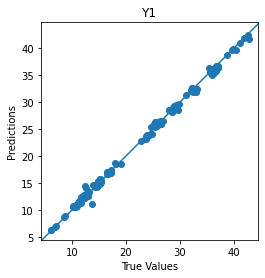

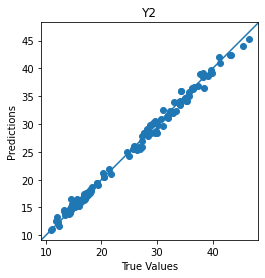

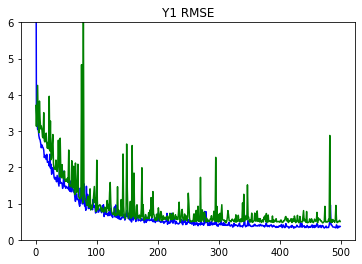

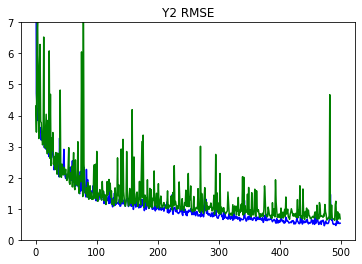

In [29]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)